In [1]:
from scipy.io import loadmat
import numpy as np
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
labels = loadmat('../data/imagelabels.mat')['labels'][0]
split = loadmat('../data/setid.mat')
train_ids = split['trnid'][0] - 1
val_ids = split['valid'][0] - 1
test_ids = split['tstid'][0] - 1


In [2]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from torchvision import transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

class FlowerDataset(Dataset):
    def __init__(self, img_dir, indices, labels, transform=None):
        self.img_dir = img_dir
        self.indices = indices
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        index = self.indices[idx] + 1
        image = Image.open(os.path.join(self.img_dir, f'image_{index:05d}.jpg')).convert('RGB')
        label = self.labels[index - 1] - 1
        if self.transform:
            image = self.transform(image)
        return image, label

def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = FlowerDataset('../data/jpg', train_ids, labels, transform)
val_dataset = FlowerDataset('../data/jpg', val_ids, labels, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


# Full training

In [ ]:
def build_model(n):
    vgg13 = models.vgg13(pretrained=True)

    layers = list(filter(lambda x: isinstance(x, nn.Conv2d), vgg13.features.children()))
    for layer in layers[:n]:
        for param in layer.parameters():
            param.requires_grad = False

    vgg13.classifier[6] = nn.Linear(vgg13.classifier[6].in_features, 102)
    vgg13 = vgg13.to(device)

    optimizer = optim.Adam(
        list(vgg13.classifier[6].parameters())
        + [param for layer in layers[n:] for param in layer.parameters()]
    , lr=0.001)
    return vgg13, optimizer


vgg13, optimizer = build_model(10)
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(15):
    vgg13.train()
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vgg13(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    val_acc = evaluate(vgg13, val_loader)
    print(f"Epoch {epoch+1}: Val Acc = {val_acc:.4f}")


/home/ventus/university/data-mining/.env/lib64/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ventus/university/data-mining/.env/lib64/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG13_Weights.IMAGENET1K_V1`. You can also use `weights=VGG13_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Val Acc = 0.5255
Epoch 2: Val Acc = 0.6294
Epoch 3: Val Acc = 0.6735
Epoch 4: Val Acc = 0.6892
Epoch 5: Val Acc = 0.7029
Epoch 6: Val Acc = 0.7069
Epoch 7: Val Acc = 0.7127
Epoch 8: Val Acc = 0.7088
Epoch 9: Val Acc = 0.7225
Epoch 10: Val Acc = 0.7167
Epoch 11: Val Acc = 0.7245
Epoch 12: Val Acc = 0.7206
Epoch 13: Val Acc = 0.7245
Epoch 14: Val Acc = 0.7176
Epoch 15: Val Acc = 0.7216


# Transfer Learning

In [ ]:
import time

results = []

for n in range(13):
    model, optimizer = build_model(n)
    model = model.to(device)
    best_acc = 0
    start_time = time.time()
    over_threshold = 30

    for epoch in range(over_threshold):
        model.train()
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        val_acc = evaluate(model, val_loader)
        print(val_acc)
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f'model_freeze_{n}.pth')

        if val_acc >= 0.95:
            over_threshold = min(over_threshold, epoch)

    elapsed_time = time.time() - start_time
    results.append((n, epoch+1, elapsed_time, best_acc, over_threshold))


0.00980392156862745
0.00980392156862745
0.027450980392156862
0.021568627450980392
0.010784313725490196
0.014705882352941176
0.022549019607843137
0.03235294117647059
0.03627450980392157
0.05588235294117647
0.041176470588235294
0.09117647058823529
0.0696078431372549
0.1
0.10098039215686275
0.1607843137254902
0.12450980392156863
0.14313725490196078
0.15490196078431373
0.13431372549019607
0.16372549019607843
0.21176470588235294
0.16176470588235295
0.20588235294117646
0.22058823529411764
0.20392156862745098
0.22941176470588234
0.21274509803921568
0.22156862745098038
0.24411764705882352
0.01764705882352941
0.0029411764705882353
0.022549019607843137
0.01568627450980392
0.026470588235294117
0.03137254901960784
0.03823529411764706
0.047058823529411764
0.04803921568627451
0.061764705882352944
0.07058823529411765
0.0892156862745098
0.09509803921568627
0.10490196078431373
0.09313725490196079
0.08823529411764706
0.11274509803921569
0.1284313725490196
0.10882352941176471
0.12941176470588237
0.173529

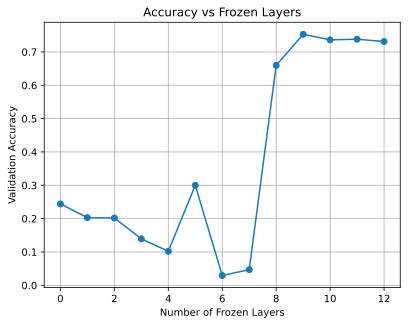

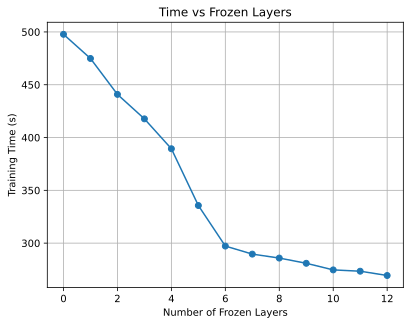

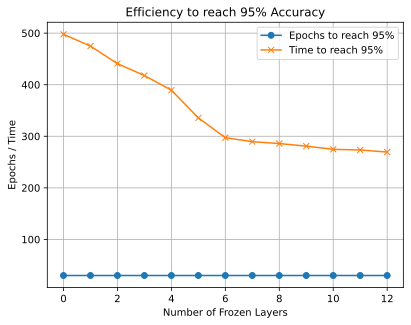

In [ ]:
import matplotlib.pyplot as plt

layers, epochs, times, accs, e95 = zip(*results)

# Plot 1: Accuracy vs Frozen Layers
plt.figure()
plt.plot(layers, accs, marker='o')
plt.xlabel("Number of Frozen Layers")
plt.ylabel("Validation Accuracy")
plt.title("Accuracy vs Frozen Layers")
plt.grid()

# Plot 2: Time vs Frozen Layers
plt.figure()
plt.plot(layers, times, marker='o')
plt.xlabel("Number of Frozen Layers")
plt.ylabel("Training Time (s)")
plt.title("Time vs Frozen Layers")
plt.grid()

plt.figure()
plt.plot(layers, e95, marker='o', label='Epochs to reach 95%')
plt.plot(layers, times, marker='x', label='Time to reach 95%')
plt.xlabel("Number of Frozen Layers")
plt.ylabel("Epochs / Time")
plt.title("Efficiency to reach 95% Accuracy")
plt.legend()
plt.grid()

plt.show()


In [6]:
accs

(0.24411764705882352,
 0.20294117647058824,
 0.2019607843137255,
 0.1392156862745098,
 0.10196078431372549,
 0.3,
 0.029411764705882353,
 0.047058823529411764,
 0.6598039215686274,
 0.7529411764705882,
 0.7362745098039216,
 0.7382352941176471,
 0.7313725490196078)